# Datasets and Dataloaders

PyTorch 提供了两个数据原语： torch.utils.data.DataLoader 和 torch.utils.data.Dataset ，允许使用预加载的数据集以及自己的数据。 

Dataset存储样本及其相应的标签， DataLoader围绕Dataset包装一个可迭代对象，以便轻松访问样本。

## 1.加载数据集

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data", # root是存储训练/测试数据的路径，
    train=True, # train指定训练或测试数据集
    download=True, # download=True从互联网下载数据（如果root不可用）。
    transform=ToTensor() # transform和target_transform指定特征和标签变换
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

## 2.迭代和可视化数据集

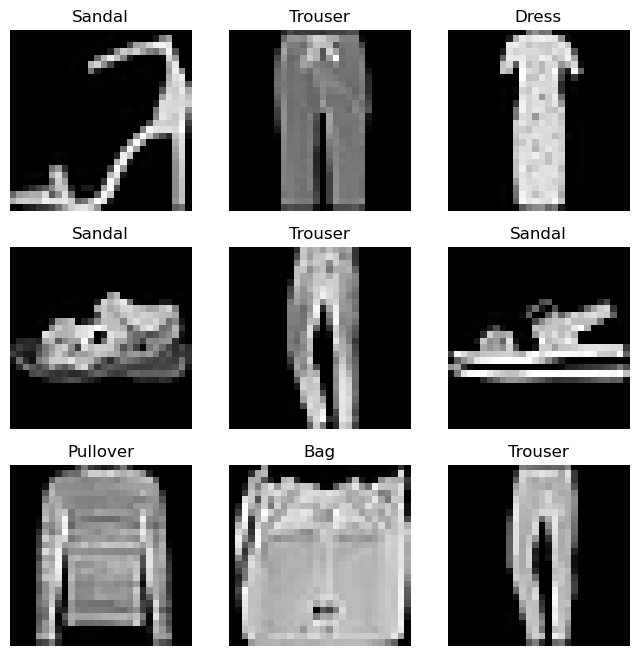

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## 3.自定义数据集
自定义 Dataset 类必须实现三个函数： __init__ 、 __len__和__getitem__ 。

FashionMNIST 图像存储在目录img_dir中，它们的标签单独存储在 CSV 文件annotations_file中。

In [5]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    # __init__ 函数在实例化 Dataset 对象时运行一次
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    # __len__ 函数返回数据集中的样本数。
    def __len__(self):
        return len(self.img_labels)

    # __getitem__ 函数加载并返回给定索引idx处的数据集的样本。基于索引，它识别图像在磁盘上的位置，
    # 使用read_image将其转换为张量，从self.img_labels中的 csv 数据中检索相应的标签，
    # 调用它们的转换函数（如果适用），然后返回张量图像以及元组中相应的标签。
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

## 4.使用 DataLoaders 准备数据以进行训练
Dataset检索数据集的特征并一次标记一个样本。在训练模型时，我们通常希望以“小批量”方式传递样本，
在每个时期重新整理数据以减少模型过度拟合，并使用 Python 的multiprocessing来加速数据检索。

In [6]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## 5.提供 DataLoader 遍历
我们已将该数据集加载到DataLoader中，并且可以根据需要迭代数据集。
下面的每次迭代都会返回一批train_features和train_labels （分别包含batch_size=64特征和标签）。因为我们指定了shuffle=True ，所以在迭代所有批次后，数据会被打乱

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


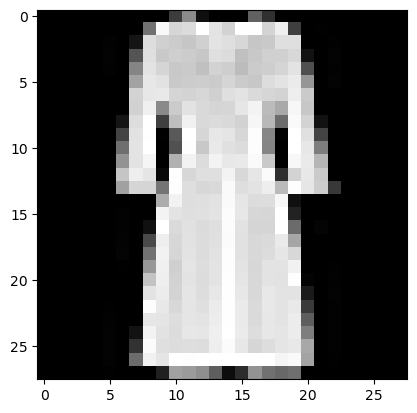

Label: 3


In [7]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")